#### Sklearn: Working with Text Data
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [1]:
# Import dependencies (packages and modules)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

#### Load the data set into jupyter notebook
The endstate is a dataframe containing a label column and text column

In [2]:
# get csv file from AWS S3 bucket
url ="https://wine-demo-bucket.s3.amazonaws.com/wine_matched_final.csv"

df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93557 entries, 0 to 93556
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             93557 non-null  object 
 1   province            93557 non-null  object 
 2   region_1            93557 non-null  object 
 3   winery              93557 non-null  object 
 4   wine_type           93557 non-null  object 
 5   wine_style          93557 non-null  object 
 6   variety             93557 non-null  object 
 7   name                93557 non-null  object 
 8   points              93557 non-null  int64  
 9   price               93557 non-null  float64
 10  points_earned       93557 non-null  int64  
 11  value_points_per_$  93557 non-null  float64
 12  description         93557 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 9.3+ MB


In [3]:
# reduce the dataframe to just wine_type and description
# this is going to be our 'label' and 'text' columns (in the cell below)
column_names = ['variety', 'description']
df = df.reindex(columns=column_names)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93557 entries, 0 to 93556
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   variety      93557 non-null  object
 1   description  93557 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [4]:
# rename wine type to 'label' and description to 'text'
df.rename(columns={"variety": 'label', "description": 'text'}, inplace=True)
data = df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93557 entries, 0 to 93556
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   93557 non-null  object
 1   text    93557 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [5]:
# how many of each wine_type are in our wine_description dataframe?
data['label'].value_counts()

Chardonnay            13351
Pinot Noir            13246
Cabernet Sauvignon    11891
Sauvignon Blanc        5970
Syrah                  5492
Riesling               5029
Merlot                 4801
Zinfandel              3792
Malbec                 3026
Sangiovese             2809
Tempranillo            2439
Rosé                   2416
Shiraz                 1841
Nebbiolo               1414
Cabernet Franc         1258
Pinot Grigio           1258
Pinot Gris             1252
Viognier               1227
Barbera                 956
Petite Sirah            887
Gewürztraminer          868
Grüner Veltliner        834
Port                    743
Chenin Blanc            631
Grenache                585
Albariño                529
Prosecco                515
Moscato                 378
Torrontés               363
Dolcetto                332
Garganega               307
Gamay                   299
Montepulciano           272
Sémillon                214
Zweigelt                199
Petit Verdot        

In [6]:
data['text'].head()

0    Mac Watson honors the memory of a wine once ma...
1    This spent 20 months in 30% new French oak, an...
2    This re-named vineyard was formerly bottled as...
3    The producer sources from two blocks of the vi...
4    From 18-year-old vines, this supple well-balan...
Name: text, dtype: object

#### Devide the data into train and test using sklearn train_test_split

In [7]:
X = data['text'] # the description
y = data['label'] # the wine type

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Extract features by tokenizing text using the bag of words technique


In [8]:
# we will tokenize and filter stop words using CountVectorizer
# this will be used to build a dictionary of features and transforms documents to feature vectors:
count_vect = CountVectorizer()
count_vect

CountVectorizer()

In [9]:
# creating bag of words for training data
# Here by doing ‘count_vect.fit_transform()’
# we are learning the vocabulary dictionary and it returns a Document-Term matrix. [n_samples, n_features].
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(70167, 22291)

#### CountVectorizer supports counts of N-grams of words or consecutive characters. Once fitted, the vectorizer has built a dictionary of feature indices:

In [10]:
# CountVectorizer supports counts of N-grams of words or consecutive characters. Once fitted, the vectorizer has built a dictionary of feature indices:
count_vect.vocabulary_.get(u'algorithm')

#### From occurrences to frequencies
From occurrences to frequencies¶Occurrence count is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

#### TF - Term Frequencies#### TF - Term Frequencies
To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

#### TF - IDF (Term Frequency times inverse document frequency)#### TF - IDF (Term Frequency times inverse document frequency)
Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.

Both tf and tf–idf can be computed as follows using TfidfTransformer:

In [11]:
# for our calculations we need to calculate TF and TF-IDF
# We can achieve both using below line of code and the X_train_counts from above:

tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

# The output will be the dimension of the Document-Term matrix -> (11314, 130107) which is the same shape as our X_train_counts shape

(70167, 22291)

#### Training a Classifier on the X_train_tfidf and y_train data
Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant

In [12]:
# from sklearn.naive_bayes import MultinomialNB - this was done under dependencies in cell [1]
clf = MultinomialNB().fit(X_train_tfidf, y_train)

#### After fitting the training set, let’s make a prediction using the first row of X_test and y_test.

To try to predict the outcome on a new document we need to extract the features using almost the same feature extracting chain as before. The difference is that we call transform instead of fit_transform on the transformers, since they have already been fit to the training set:

In [13]:
# we are going to want the text from a row (take first row) of X_test
new_description = [X_test.iloc[0]]

new_description

['While there are plenty of firm tannins and weight here, the wine does feel somewhat hollow. The red fruits are there, showing slowly against the tannins. It has fine final acidity, but not the power and concentration you should expect.']

In [14]:
# if we enter this into a prediction it should produce the y_test.iloc[0] category
y_test.iloc[0]

'Pinot Noir'

####  Build a pipeline
In order to make the vectorizer => transformer => classifier easier to work with, scikit-learn provides a Pipeline class that behaves like a compound classifier:




In [15]:
# MultinomialNb
# The names vect, tfidf and clf (classifier) are arbitrary. 
# We will use them to perform grid search for suitable hyperparameters below. 
# We can now train the model with a single command:

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [16]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

#### Evaluation of the performance of the MultinomialNb model on the test set
Evaluating the predictive accuracy of the model is equally easy:

In [17]:
#>>> docs_test = twenty_test.data
#>>> predicted = text_clf.predict(docs_test)
#>>> np.mean(predicted == twenty_test.target)
#0.8348...

docs_test = data['text']
predicted = text_clf.predict(docs_test)
np.mean(predicted == data['label'])

0.48341652682322006

We achieved 94.5% accuracy. Let’s see if we can do better with a linear support vector machine (SVM), which is widely regarded as one of the best text classification algorithms (although it’s also a bit slower than naïve Bayes). We can change the learner by simply plugging a different classifier object into our pipeline:

In [18]:
# using Support Vector Machine classifier with Stochastic gradient descent (SGD) learning
# note there are many parameters for SGDClassifier - for the first iteration we will use default parameter values

text_clf = Pipeline ([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())
])

text_clf.fit(data['text'], data['label'])

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier())])

In [19]:
predicted = text_clf.predict(data['text'])
np.mean(predicted == data['label'])

0.8139636798956785

We achieved 96.6% accuracy using the SVM. scikit-learn provides further utilities for more detailed performance analysis of the results:

In [20]:
print(metrics.classification_report(data['label'], predicted))

                    precision    recall  f1-score   support

          Albariño       0.94      0.60      0.73       529
           Barbera       0.92      0.84      0.88       956
     Blaufränkisch       0.90      0.72      0.80       187
    Cabernet Franc       0.81      0.52      0.63      1258
Cabernet Sauvignon       0.76      0.85      0.81     11891
        Chardonnay       0.79      0.96      0.86     13351
         Chasselas       0.14      0.20      0.17         5
      Chenin Blanc       0.95      0.58      0.72       631
          Cinsault       0.12      0.28      0.17        25
          Dolcetto       0.94      0.84      0.89       332
          Frappato       0.53      0.63      0.58        30
             Gamay       0.81      0.58      0.68       299
         Garganega       1.00      0.85      0.92       307
    Gewürztraminer       0.91      0.76      0.83       868
          Grenache       0.78      0.44      0.56       585
    Grenache Blanc       0.73      0.11

In [21]:
metrics.confusion_matrix(data['label'], predicted)

array([[ 318,    0,    0, ...,    1,    0,    0],
       [   0,  802,    0, ...,    1,   11,    0],
       [   0,    0,  134, ...,    0,    0,    1],
       ...,
       [   0,    0,    0, ...,  765,    4,    0],
       [   0,    9,    0, ...,    0, 3106,    0],
       [   0,    0,    0, ...,    0,    0,  155]], dtype=int64)

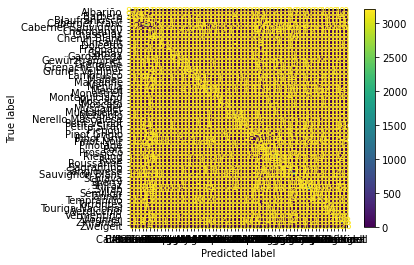

In [22]:
plot_confusion_matrix(text_clf, X_test, y_test)  

#### Parameter tuning using grid search

We’ve already encountered some parameters such as use_idf in the TfidfTransformer. Classifiers tend to have many parameters as well; e.g., MultinomialNB includes a smoothing parameter alpha and SGDClassifier has a penalty parameter alpha and configurable loss and penalty terms in the objective function (see the module documentation, or use the Python help function to get a description of these).

Instead of tweaking the parameters of the various components of the chain, it is possible to run an exhaustive search of the best parameters on a grid of possible values. We try out all classifiers on either words or bigrams, with or without idf, and with a penalty parameter of either 0.01 or 0.001 for the linear SVM:

In [23]:
# parameter tuning of the SGDClassifier()
# note: sklearn.model_selection import GridSearchCV  was imported with dependencies
# note below (1e-2, 1e-3) is the same as 0.01 or 0.001
parameters = {
    'vect__ngram_range': [(1,1), (1,2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
}

Obviously, such an exhaustive search can be expensive. If we have multiple CPU cores at our disposal, we can tell the grid searcher to try these eight parameter combinations in parallel with the n_jobs parameter. If we give this parameter a value of -1, grid search will detect how many cores are installed and use them all:

In [24]:
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [ ]:
gs_clf = gs_clf.fit(data['text'], data['label'])

C:\Users\jamie\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The object’s best_score_ and best_params_ attributes store the best mean score and the parameters setting corresponding to that score:

In [ ]:
gs_clf.best_score_

In [ ]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

In [ ]:
# A more detailed summary of the search is available at gs_clf.cv_results_.
# gs_clf.cv_results_

Using parameter tuning for the parameters above did not improve over the default parameters
93.88 vs. 96.6 for 96.6% accuracy using the SVM with default parameters
TODO: confirm default parameters are valid

#### Next Step would be to examine performance of using a label of the nine wine_styles
Note sklearn how to states:
if you have multiple labels per document, e.g categories, have a look at the Multiclass and multilabel section.

https://scikit-learn.org/stable/modules/multiclass.html#multiclass

#### Review article on towards data science on multi-class-text-classification
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f